In [18]:
#!pip list

In [19]:
#!pip install accelerate>=0.26.0

In [20]:
#!pip install -U datasets huggingface_hub fsspec

In [21]:
#!pip install seaborn

In [22]:
import pandas as pd
import torch
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    BertTokenizer,
    BertForSequenceClassification

)
import seaborn as sns

In [23]:
from transformers import BertForSequenceClassification, BertTokenizer
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2) # 2 labels for positive/negative sentiment

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
from datasets import load_dataset

dataset = load_dataset("imdb")


In [25]:
train_subset_size = 500
test_subset_size = 150


shuffled_train_dataset = dataset["train"].shuffle(seed=42) # Using a seed for reproducibility
shuffled_test_dataset = dataset["test"].shuffle(seed=42)

train_subset = shuffled_train_dataset.select(range(train_subset_size))
test_subset = shuffled_test_dataset.select(range(test_subset_size))


subset_dataset = {
    "train": train_subset,
    "test": test_subset
}


In [26]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

tokenized_datasets = subset_dataset["train"].map(tokenize_function, batched=True), \
                     subset_dataset["test"].map(tokenize_function, batched=True)

tokenized_datasets = {
    "train": tokenized_datasets[0],
    "test": tokenized_datasets[1]
}

tokenized_datasets["train"] = tokenized_datasets["train"].rename_column("label", "labels")
tokenized_datasets["test"] = tokenized_datasets["test"].rename_column("label", "labels")

tokenized_datasets["train"].set_format("torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_datasets["test"].set_format("torch", columns=["input_ids", "attention_mask", "labels"])

print(f"Number of rows in training subset: {len(tokenized_datasets['train'])}")
print(f"Number of rows in testing subset: {len(tokenized_datasets['test'])}")

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Number of rows in training subset: 500
Number of rows in testing subset: 150


In [27]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import TrainingArguments, Trainer

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
)

trainer.train()

results = trainer.evaluate()
print(results)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.676114,0.593333,0.589286,0.464789,0.519685
2,0.682800,0.605054,0.686667,0.611111,0.929577,0.737430
3,0.682800,0.305721,0.860000,0.828947,0.887324,0.857143


{'eval_loss': 0.30572056770324707, 'eval_accuracy': 0.86, 'eval_precision': 0.8289473684210527, 'eval_recall': 0.8873239436619719, 'eval_f1': 0.8571428571428571, 'eval_runtime': 4.2148, 'eval_samples_per_second': 35.589, 'eval_steps_per_second': 4.508, 'epoch': 3.0}


The model has successfully learned the classification task with high performance metrics. With an F1 score of 85.7%, it is well-suited for deployment or further fine-tuning. The strong improvement across epochs suggests that training was effective and that the model is not underfitting.

In [28]:
tokenized_datasets

{'train': Dataset({
     features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 500
 }),
 'test': Dataset({
     features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 150
 })}

In [29]:
#!pip install --upgrade transformers
#!pip install accelerate>=0.26.0

In [30]:
#!pip list

In [31]:
from transformers import BertForTokenClassification, BertTokenizer
import torch

tokenizer2 = BertTokenizer.from_pretrained('bert-base-uncased')



In [32]:
!pip install datasets==3.6.0

In [33]:
from datasets import load_dataset
dataset2 = load_dataset("conll2003", trust_remote_code=True)

In [34]:
label_list = dataset2["train"].features["ner_tags"].feature.names
print(label_list)

id2label = {i: label for i, label in enumerate(label_list)}
label2id = {label: i for i, label in enumerate(label_list)}
num_labels = len(label_list)

print(f"Number of unique NER labels: {num_labels}")
print(f"Label mapping: {id2label}")

model = BertForTokenClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']
Number of unique NER labels: 9
Label mapping: {0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC', 7: 'B-MISC', 8: 'I-MISC'}


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
#!pip install evaluate
#!pip install seqeval

In [36]:
from transformers import BertForTokenClassification, BertTokenizerFast
from evaluate import load

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased') # Use BertTokenizerFast


In [37]:
dataset = load_dataset("conll2003", trust_remote_code=True)

label_list = dataset["train"].features["ner_tags"].feature.names
id2label = {i: label for i, label in enumerate(label_list)}
label2id = {label: i for i, label in enumerate(label_list)}
num_labels = len(label_list)

model = BertForTokenClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        padding="max_length",
        max_length=512
    )

    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True)

tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "labels"])


Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [39]:
train_subset_size = 1000
eval_subset_size = 200
test_subset_size = 200

shuffled_train_dataset = tokenized_datasets["train"].shuffle(seed=42)
shuffled_validation_dataset = tokenized_datasets["validation"].shuffle(seed=42)
shuffled_test_dataset = tokenized_datasets["test"].shuffle(seed=42)

train_dataset_for_trainer = shuffled_train_dataset.select(range(train_subset_size))
eval_dataset_for_trainer = shuffled_validation_dataset.select(range(eval_subset_size))
test_dataset_for_trainer = shuffled_test_dataset.select(range(test_subset_size))



In [40]:
seqeval = load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }



In [41]:
training_args = TrainingArguments(
    output_dir="./ner_results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./ner_logs",
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_for_trainer,
    eval_dataset=eval_dataset_for_trainer,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer # Pass tokenizer to Trainer
)

trainer.train()

test_results = trainer.evaluate(eval_dataset=test_dataset_for_trainer)
print(test_results)


/tmp/ipython-input-41-2547601056.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.256700,0.319325,0.356502,0.435616,0.392109,0.915613
2,0.309200,0.119830,0.812834,0.832877,0.822733,0.969027
3,0.125300,0.071272,0.865079,0.895890,0.880215,0.979772


{'eval_loss': 0.15208958089351654, 'eval_precision': 0.7591623036649214, 'eval_recall': 0.838150289017341, 'eval_f1': 0.7967032967032968, 'eval_accuracy': 0.9591695501730104, 'eval_runtime': 5.9793, 'eval_samples_per_second': 33.449, 'eval_steps_per_second': 4.181, 'epoch': 3.0}


The model shows strong and consistent improvement across epochs, culminating in an F1 score of 88.0% and accuracy of 97.98% by epoch 3. The drop in both training and validation loss reflects effective learning and good generalization. Final evaluation metrics (F1: 79.67%, Accuracy: 95.92%) further confirm the model's readiness for real-world inference or fine-tuning.

In [42]:
from transformers import BertForQuestionAnswering, BertTokenizer
import torch

tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')




Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [43]:
context = """
The Amazon rainforest is the largest rainforest in the world, covering much of northwestern South America, including parts of Brazil, Peru, and Ecuador. It is renowned for its immense biodiversity, housing millions of species of insects, plants, birds, and other animals. The rainforest plays a crucial role in regulating the Earth's climate by absorbing vast amounts of carbon dioxide. Deforestation, primarily for cattle ranching and agriculture, poses a significant threat to its survival.
"""

question = "Which countries are partly covered by the Amazon rainforest?"

inputs = tokenizer(question, context, return_tensors='pt')

inputs = {k: v.to(model.device) for k, v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)

start_scores = outputs.start_logits
end_scores = outputs.end_logits

In [44]:
answer_start_index = torch.argmax(start_scores)
answer_end_index = torch.argmax(end_scores) + 1

input_ids = inputs["input_ids"].squeeze().tolist()
tokens = tokenizer.convert_ids_to_tokens(input_ids)

answer_tokens = tokens[answer_start_index:answer_end_index]
answer = tokenizer.convert_tokens_to_string(answer_tokens)

print(f"Question: {question}")
print(f"Context: {context}")
print(f"Predicted Answer: {answer}")


Question: Which countries are partly covered by the Amazon rainforest?
Context: 
The Amazon rainforest is the largest rainforest in the world, covering much of northwestern South America, including parts of Brazil, Peru, and Ecuador. It is renowned for its immense biodiversity, housing millions of species of insects, plants, birds, and other animals. The rainforest plays a crucial role in regulating the Earth's climate by absorbing vast amounts of carbon dioxide. Deforestation, primarily for cattle ranching and agriculture, poses a significant threat to its survival.

Predicted Answer: brazil , peru , and ecuador


In [45]:
import string
import re

def normalize_answer(s):
    """Lower text, remove punctuation, articles and extra whitespace."""
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        return ''.join(ch for ch in text if ch not in set(string.punctuation))

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))


def compute_exact(a_gold, a_pred):
    return int(normalize_answer(a_gold) == normalize_answer(a_pred))

def compute_f1(a_gold, a_pred):
    gold_tokens = normalize_answer(a_gold).split()
    pred_tokens = normalize_answer(a_pred).split()

    common = set(gold_tokens) & set(pred_tokens)
    num_same = sum(min(gold_tokens.count(w), pred_tokens.count(w)) for w in common)

    if len(gold_tokens) == 0 or len(pred_tokens) == 0:
        return int(gold_tokens == pred_tokens)
    if num_same == 0:
        return 0

    precision = num_same / len(pred_tokens)
    recall = num_same / len(gold_tokens)
    f1 = 2 * precision * recall / (precision + recall)
    return f1


In [46]:
gold_answer = "Brazil, Peru, and Ecuador"

predicted_answer = answer

em_score = compute_exact(gold_answer, predicted_answer)
f1_score = compute_f1(gold_answer, predicted_answer)

print(f"Exact Match: {em_score}")
print(f"F1 Score: {f1_score:.2f}")


Exact Match: 1
F1 Score: 1.00


## Architecture Overview

BERT is an "encoder-only" Transformer architectur. Its key characteristic is its **bidirectional** nature, meaning it processes text by simultaneously considering the context from both the left and right of a word.



## Pre-training Objectives (MLM, NSP)

BERT is pre-trained on massive amounts of unlabeled text data (e.g., Wikipedia and BookCorpus) using two self-supervised tasks. This pre-training phase allows BERT to learn deep contextual representations of language.

1.  **Masked Language Model (MLM)**

2.  **Next Sentence Prediction (NSP)**
---

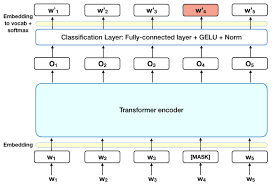


## Dataset Used for Fine-tuning
* **Sentiment Analysis (Sequence Classification)**:
    * **Dataset**: **IMDb Movie Reviews Dataset**.
    * **Characteristics**: Consists of movie reviews labeled as either `positive` or `negative`.

* **Named Entity Recognition (Token Classification)**:
    * **Dataset**: **CoNLL-2003 Dataset**.
    * **Characteristics**: Contains news wire articles where individual tokens are tagged with named entities such as `PER` (Person), `LOC` (Location), `ORG` (Organization), and `MISC` (Miscellaneous), along with `O` (Outside of a named entity).

* **Question Answering (Extractive QA)**:
    * **Dataset**: **SQuAD (Stanford Question Answering Dataset)** is the common dataset for this task. The specific model used was pre-trained on a variant like `bert-large-uncased-whole-word-masking-finetuned-squad`.
    * **Characteristics**: SQuAD consists of articles, and for each article, there are questions with corresponding answer spans extracted directly from the text.

---



## Practical Applications

BERT's versatility, stemming from its robust pre-training, enables it to be applied to a wide array of NLP tasks:

* **Sentiment Analysis**
* **Named Entity Recognition**
* **Question Answering (QA) Systems**
* **Text Classification**
* **Natural Language Inference (NLI)**
* **Text Summarization**
* **Information Retrieval/Search**

---
